In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model_train import *
from torch.optim import SGD,Adam
from torch.optim import lr_scheduler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(1024, kernel_regularizer = 'l2', activation = 'relu', input_shape=(1*18,)))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer='adam',
                  loss='msle',
                  metrics=['mae', 'msle'])
    return model

In [4]:
df = pd.read_feather(os.path.join(DATA_DIR,'mae_drop.feather'))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\39320\\Progetti\\bike\\dataset\\mae_drop.feather'

In [48]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
temp = pd.DataFrame(encoder.fit_transform(df['step'].values.reshape(-1,1)), columns = ['step'+str(el) for el in range(1,15)])
df_encoded = df.drop('step', axis = 1).merge(temp, left_index = True, right_index=True)

In [73]:
mean = df_encoded.mean(axis = 0)[['mae','dropout']].values # [mae_mean, dropout_mean]
var = df_encoded.var(axis = 0)[['mae','dropout']].values # [mae_var, dropout_var]
df_encoded['mae'] = (df_encoded['mae'] - mean[0])/var[0]
df_encoded['dropout'] = (df_encoded['dropout'] - mean[1])/var[1]

C:\Users\39320\AppData\Local\Temp\ipykernel_17496\1082319244.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = df_encoded.mean(axis = 0)[['mae','dropout']].values # [mae_mean, dropout_mean]
C:\Users\39320\AppData\Local\Temp\ipykernel_17496\1082319244.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var = df_encoded.var(axis = 0)[['mae','dropout']].values # [mae_var, dropout_var]


In [68]:
train,test = train_test_split(df_encoded,test_size = 0.3, random_state = 1)
train_dataset = MaeDataset(train)
test_dataset = MaeDataset(test)

train_loader=DataLoader(train_dataset,batch_size = 32,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size = 32,shuffle=False)

In [69]:
# model's parameters
lr = 0.05
num_epochs = 30
log_interval = 100

# model
model = MLP(15,200,15)

# Optimization
optimizer = Adam(model.parameters(), lr = lr, weight_decay = 0.0001)
# Learning Rate schedule
scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.5)

In [58]:
test.iloc[:,2:]

,dropout,step1,step2,step3,step4,step5,step6,step7,step8,step9,step10,step11,step12,step13,step14
4704,2.398107e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5570,8.890094e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
250,3.158635e+02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1727,3.923048e+02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2610,9.352842e+02,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139,2.621893e+02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5061,2.403092e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1542,2.445182e+01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2991,2.446136e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
statistics = training_loop(num_epochs, optimizer, scheduler,
                           log_interval, model, train_loader,
                           test_loader)

c:\users\39320\netlov\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\users\39320\netlov\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.02] - Val = [0.02]  Time one epoch (s): 6.6684 
Epoch: 2  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.02] - Val = [0.02]  Time one epoch (s): 6.2050 
Epoch: 3  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.02] - Val = [0.02]  Time one epoch (s): 6.2339 
Epoch: 4  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.02] - Val = [0.02]  Time one epoch (s): 6.4431 
Epoch: 5  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.02] - Val = [0.02]  Time one epoch (s): 6.6145 
Epoch: 6  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.02] - Val = [0.02]  Time one epoch (s): 7.0864 
Epoch: 7  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.02] - Val = [0.02]  Time one epoch (s): 6.7274 
Epoch: 8  Lr: 0.00625000  Loss: Train = [0.0004] - Val = [0.0000]  MAE: Train = [0.

In [75]:
best_epoch_loss = np.argmin(statistics['loss_values_val']) + 1
best_loss= statistics['loss_values_val'][best_epoch_loss - 1]

best_epoch_mae = np.argmin(statistics['val_mae_values']) + 1
best_mae= statistics['val_mae_values'][best_epoch_loss - 1]

print(f'Best val loss: {best_loss: .5f} epoch: {best_epoch_loss}.\n \n'
      f'Best mae: {best_mae:.5f} epoch: {best_epoch_mae}')

Best val loss:  0.00043 epoch: 21.
 
Best mae: 0.02104 epoch: 27


C:\Users\39320\AppData\Local\Temp\ipykernel_17496\3850566496.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(x,dtype=torch.float32)


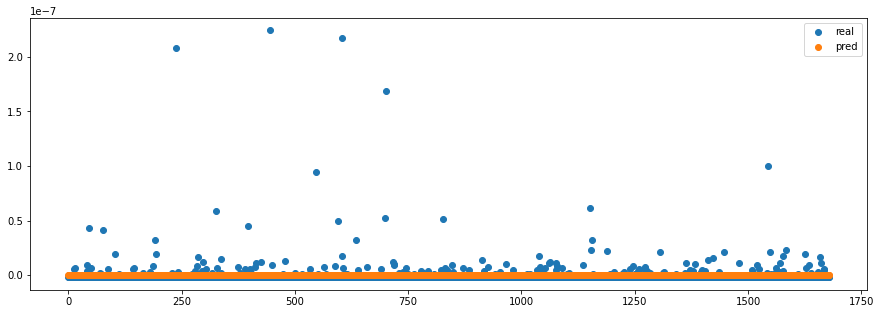

In [76]:
with torch.no_grad():
    prediction = []
    for el in range(len(test)):
        x = test.iloc[el,2:]
        y = test.iloc[el,1]

        x = torch.tensor(x,dtype=torch.float32)
        y = torch.tensor(x,dtype=torch.float32)

        prediction.append(model(x).detach().numpy())

res = pd.DataFrame([np.array(prediction).reshape(-1),test['mae'].values]).T
res.rename(columns = {0:'pred',1:'real'}, inplace = True)
res = res.apply(lambda x: x * var[0] + mean[0])

plt.figure(figsize=(15,5))
plt.scatter(list(res.index), res['real'], label = 'real')
plt.scatter(list(res.index), res['pred'], label = 'pred')
plt.legend()
plt.show()

In [77]:
res

,pred,real
0,9.142441e-11,-2.043755e-09
1,9.142441e-11,-2.046568e-09
2,9.142441e-11,-2.015268e-09
3,9.142441e-11,-1.697801e-09
4,9.142441e-11,-2.026086e-09
...,...,...
1675,9.142441e-11,-1.959700e-09
1676,9.142441e-11,-1.977075e-10
1677,9.142441e-11,-2.048829e-09
1678,9.142441e-11,-2.051797e-09
